#### About

> Case study on predicting best customers and their LTV(Life time value)

> Dataset Link - https://www.kaggle.com/datasets/carrie1/ecommerce-data

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
import numpy as np

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance


In [2]:
df = pd.read_csv('/home/suraj/kaggle_datasets/data.csv',encoding='latin-1')


In [3]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France


In [4]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

#### 1. Data Pre-processing and Feature Engineering

In [5]:
# Step 1: Check for missing values
print(df.isnull().sum())


InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


In [6]:
# Step 2: Check for duplicates
print(df.duplicated().sum())
df.drop_duplicates(inplace=True)



5268


In [7]:
# Step 3: Convert data types
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
print(df.dtypes)



InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object


In [8]:
# Step 4: Extract date and time features
df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month
df['Day'] = df['InvoiceDate'].dt.day
df['Hour'] = df['InvoiceDate'].dt.hour
df['Minute'] = df['InvoiceDate'].dt.minute
df['Second'] = df['InvoiceDate'].dt.second



In [9]:
# Step 5: Handle categorical variables
#df_encoded = pd.get_dummies(df, columns=['StockCode', 'Description', 'Country'])
# 
df['StockCode_Encoded'] = pd.factorize(df['StockCode'])[0]
df['Description_Encoded'] = pd.factorize(df['Description'])[0]
df['Country_Encoded'] = pd.factorize(df['Country'])[0]


#dropping rest columns
# Drop StockCode, Description, and Country columns
df.drop(['StockCode', 'Description', 'Country'], axis=1, inplace=True)



In [10]:
df

,InvoiceNo,Quantity,InvoiceDate,UnitPrice,CustomerID,Year,Month,Day,Hour,Minute,Second,StockCode_Encoded,Description_Encoded,Country_Encoded
0,536365,6,2010-12-01 08:26:00,2.55,17850.0,2010,12,1,8,26,0,0,0,0
1,536365,6,2010-12-01 08:26:00,3.39,17850.0,2010,12,1,8,26,0,1,1,0
2,536365,8,2010-12-01 08:26:00,2.75,17850.0,2010,12,1,8,26,0,2,2,0
3,536365,6,2010-12-01 08:26:00,3.39,17850.0,2010,12,1,8,26,0,3,3,0
4,536365,6,2010-12-01 08:26:00,3.39,17850.0,2010,12,1,8,26,0,4,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
541904,581587,12,2011-12-09 12:50:00,0.85,12680.0,2011,12,9,12,50,0,2051,2017,1
541905,581587,6,2011-12-09 12:50:00,2.10,12680.0,2011,12,9,12,50,0,415,416,1
541906,581587,4,2011-12-09 12:50:00,4.15,12680.0,2011,12,9,12,50,0,3299,3211,1
541907,581587,4,2011-12-09 12:50:00,4.15,12680.0,2011,12,9,12,50,0,3315,3217,1


> Remarks 

Using pd.factorise instead of pd.get_dummies as it is more memory efficient

pd.factorize() is more memory-efficient than pd.get_dummies() since it maps each unique value to a corresponding integer code, which requires less memory to store. This can be an advantage when working with large datasets or when the number of unique values is very large.

<Axes: ylabel='Quantity'>

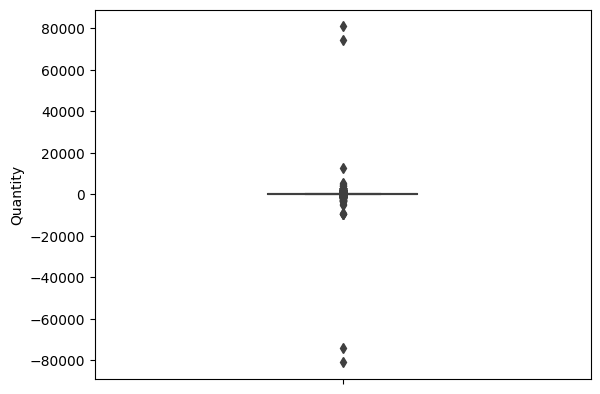

In [11]:
# Step 6: Check for outliers

# Create vertical box plot with custom percentiles
sns.boxplot(y=df['Quantity'], whis=(1, 99), width=.3)



<Axes: ylabel='UnitPrice'>

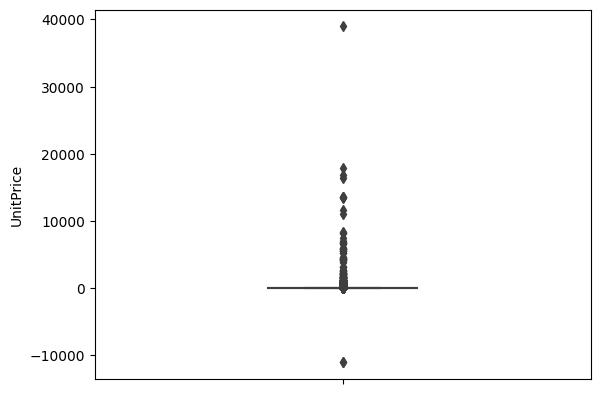

In [12]:
sns.boxplot(y=df['UnitPrice'], whis=(1, 99), width=.3)

In [13]:
df

,InvoiceNo,Quantity,InvoiceDate,UnitPrice,CustomerID,Year,Month,Day,Hour,Minute,Second,StockCode_Encoded,Description_Encoded,Country_Encoded
0,536365,6,2010-12-01 08:26:00,2.55,17850.0,2010,12,1,8,26,0,0,0,0
1,536365,6,2010-12-01 08:26:00,3.39,17850.0,2010,12,1,8,26,0,1,1,0
2,536365,8,2010-12-01 08:26:00,2.75,17850.0,2010,12,1,8,26,0,2,2,0
3,536365,6,2010-12-01 08:26:00,3.39,17850.0,2010,12,1,8,26,0,3,3,0
4,536365,6,2010-12-01 08:26:00,3.39,17850.0,2010,12,1,8,26,0,4,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
541904,581587,12,2011-12-09 12:50:00,0.85,12680.0,2011,12,9,12,50,0,2051,2017,1
541905,581587,6,2011-12-09 12:50:00,2.10,12680.0,2011,12,9,12,50,0,415,416,1
541906,581587,4,2011-12-09 12:50:00,4.15,12680.0,2011,12,9,12,50,0,3299,3211,1
541907,581587,4,2011-12-09 12:50:00,4.15,12680.0,2011,12,9,12,50,0,3315,3217,1


In [14]:
# Step 7: Normalize numerical features
scaler = MinMaxScaler()
df[['Quantity', 'UnitPrice']] = scaler.fit_transform(df[['Quantity', 'UnitPrice']])

In [15]:
df['Revenue'] = df['Quantity'] * df['UnitPrice']

In [16]:
df

,InvoiceNo,Quantity,InvoiceDate,UnitPrice,CustomerID,Year,Month,Day,Hour,Minute,Second,StockCode_Encoded,Description_Encoded,Country_Encoded,Revenue
0,536365,0.500037,2010-12-01 08:26:00,0.221150,17850.0,2010,12,1,8,26,0,0,0,0,0.110583
1,536365,0.500037,2010-12-01 08:26:00,0.221167,17850.0,2010,12,1,8,26,0,1,1,0,0.110592
2,536365,0.500049,2010-12-01 08:26:00,0.221154,17850.0,2010,12,1,8,26,0,2,2,0,0.110588
3,536365,0.500037,2010-12-01 08:26:00,0.221167,17850.0,2010,12,1,8,26,0,3,3,0,0.110592
4,536365,0.500037,2010-12-01 08:26:00,0.221167,17850.0,2010,12,1,8,26,0,4,4,0,0.110592
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
541904,581587,0.500074,2011-12-09 12:50:00,0.221116,12680.0,2011,12,9,12,50,0,2051,2017,1,0.110575
541905,581587,0.500037,2011-12-09 12:50:00,0.221141,12680.0,2011,12,9,12,50,0,415,416,1,0.110579
541906,581587,0.500025,2011-12-09 12:50:00,0.221182,12680.0,2011,12,9,12,50,0,3299,3211,1,0.110597
541907,581587,0.500025,2011-12-09 12:50:00,0.221182,12680.0,2011,12,9,12,50,0,3315,3217,1,0.110597


In [17]:
# Convert InvoiceDate column to Unix timestamps
df['InvoiceDate'] = df['InvoiceDate'].apply(lambda x: int(x.timestamp()))


In [18]:
df

,InvoiceNo,Quantity,InvoiceDate,UnitPrice,CustomerID,Year,Month,Day,Hour,Minute,Second,StockCode_Encoded,Description_Encoded,Country_Encoded,Revenue
0,536365,0.500037,1291191960,0.221150,17850.0,2010,12,1,8,26,0,0,0,0,0.110583
1,536365,0.500037,1291191960,0.221167,17850.0,2010,12,1,8,26,0,1,1,0,0.110592
2,536365,0.500049,1291191960,0.221154,17850.0,2010,12,1,8,26,0,2,2,0,0.110588
3,536365,0.500037,1291191960,0.221167,17850.0,2010,12,1,8,26,0,3,3,0,0.110592
4,536365,0.500037,1291191960,0.221167,17850.0,2010,12,1,8,26,0,4,4,0,0.110592
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
541904,581587,0.500074,1323435000,0.221116,12680.0,2011,12,9,12,50,0,2051,2017,1,0.110575
541905,581587,0.500037,1323435000,0.221141,12680.0,2011,12,9,12,50,0,415,416,1,0.110579
541906,581587,0.500025,1323435000,0.221182,12680.0,2011,12,9,12,50,0,3299,3211,1,0.110597
541907,581587,0.500025,1323435000,0.221182,12680.0,2011,12,9,12,50,0,3315,3217,1,0.110597


In [19]:
df.columns

Index(['InvoiceNo', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID',
       'Year', 'Month', 'Day', 'Hour', 'Minute', 'Second', 'StockCode_Encoded',
       'Description_Encoded', 'Country_Encoded', 'Revenue'],
      dtype='object')

In [20]:
print(df['CustomerID'].unique())

[17850. 13047. 12583. ... 13298. 14569. 12713.]


Grouping data by 'CustomerID' and compute total revenue and total transaction for each customer


In [21]:
# Compute total revenue for each customer
customer_revenue = df.groupby('CustomerID')['Revenue'].sum()
customer_revenue = pd.DataFrame(customer_revenue).reset_index()
customer_revenue.columns = ['CustomerID', 'TotalRevenue']

# Compute number of transactions for each customer
customer_frequency = df.groupby('CustomerID')['InvoiceNo'].nunique()
customer_frequency = pd.DataFrame(customer_frequency).reset_index()
customer_frequency.columns = ['CustomerID', 'TotalTransactions']


# converting to float
customer_revenue['CustomerID'] = customer_revenue['CustomerID'].astype(float)
customer_frequency['CustomerID'] = customer_frequency['CustomerID'].astype(float)



In [22]:
print(customer_revenue['CustomerID'].unique())
print(customer_frequency['CustomerID'].unique())
print(df['CustomerID'].unique())

print(customer_revenue['CustomerID'].shape)
print(customer_frequency['CustomerID'].shape)
print(df['CustomerID'].shape)


[12346. 12347. 12348. ... 18282. 18283. 18287.]
[12346. 12347. 12348. ... 18282. 18283. 18287.]
[17850. 13047. 12583. ... 13298. 14569. 12713.]
(4372,)
(4372,)
(536641,)


In [23]:
# Merge new features with original dataframe
df = pd.merge(df, customer_revenue, on='CustomerID')
df = pd.merge(df, customer_frequency, on='CustomerID')


In [24]:
df

,InvoiceNo,Quantity,InvoiceDate,UnitPrice,CustomerID,Year,Month,Day,Hour,Minute,Second,StockCode_Encoded,Description_Encoded,Country_Encoded,Revenue,TotalRevenue,TotalTransactions
0,536365,0.500037,1291191960,0.221150,17850.0,2010,12,1,8,26,0,0,0,0,0.110583,34.174266,35
1,536365,0.500037,1291191960,0.221167,17850.0,2010,12,1,8,26,0,1,1,0,0.110592,34.174266,35
2,536365,0.500049,1291191960,0.221154,17850.0,2010,12,1,8,26,0,2,2,0,0.110588,34.174266,35
3,536365,0.500037,1291191960,0.221167,17850.0,2010,12,1,8,26,0,3,3,0,0.110592,34.174266,35
4,536365,0.500037,1291191960,0.221167,17850.0,2010,12,1,8,26,0,4,4,0,0.110592,34.174266,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401599,581578,0.500074,1323432960,0.221124,12713.0,2011,12,9,12,16,0,3108,3008,4,0.110579,4.202533,1
401600,581578,0.500074,1323432960,0.221116,12713.0,2011,12,9,12,16,0,607,608,4,0.110575,4.202533,1
401601,581578,0.500074,1323432960,0.221116,12713.0,2011,12,9,12,16,0,1689,1672,4,0.110575,4.202533,1
401602,581578,0.500074,1323432960,0.221141,12713.0,2011,12,9,12,16,0,3516,3465,4,0.110587,4.202533,1


In [25]:
# Drop rows 
df.drop(['CustomerID','InvoiceNo'], axis=1, inplace=True)

# Convert boolean True and False values to numeric
df = df.astype(float)

In [26]:
# Select non-numeric columns
non_numeric_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()

# Print non-numeric columns
print(non_numeric_cols)

[]


In [27]:
df

,Quantity,InvoiceDate,UnitPrice,Year,Month,Day,Hour,Minute,Second,StockCode_Encoded,Description_Encoded,Country_Encoded,Revenue,TotalRevenue,TotalTransactions
0,0.500037,1.291192e+09,0.221150,2010.0,12.0,1.0,8.0,26.0,0.0,0.0,0.0,0.0,0.110583,34.174266,35.0
1,0.500037,1.291192e+09,0.221167,2010.0,12.0,1.0,8.0,26.0,0.0,1.0,1.0,0.0,0.110592,34.174266,35.0
2,0.500049,1.291192e+09,0.221154,2010.0,12.0,1.0,8.0,26.0,0.0,2.0,2.0,0.0,0.110588,34.174266,35.0
3,0.500037,1.291192e+09,0.221167,2010.0,12.0,1.0,8.0,26.0,0.0,3.0,3.0,0.0,0.110592,34.174266,35.0
4,0.500037,1.291192e+09,0.221167,2010.0,12.0,1.0,8.0,26.0,0.0,4.0,4.0,0.0,0.110592,34.174266,35.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401599,0.500074,1.323433e+09,0.221124,2011.0,12.0,9.0,12.0,16.0,0.0,3108.0,3008.0,4.0,0.110579,4.202533,1.0
401600,0.500074,1.323433e+09,0.221116,2011.0,12.0,9.0,12.0,16.0,0.0,607.0,608.0,4.0,0.110575,4.202533,1.0
401601,0.500074,1.323433e+09,0.221116,2011.0,12.0,9.0,12.0,16.0,0.0,1689.0,1672.0,4.0,0.110575,4.202533,1.0
401602,0.500074,1.323433e+09,0.221141,2011.0,12.0,9.0,12.0,16.0,0.0,3516.0,3465.0,4.0,0.110587,4.202533,1.0


In [28]:
df.columns

Index(['Quantity', 'InvoiceDate', 'UnitPrice', 'Year', 'Month', 'Day', 'Hour',
       'Minute', 'Second', 'StockCode_Encoded', 'Description_Encoded',
       'Country_Encoded', 'Revenue', 'TotalRevenue', 'TotalTransactions'],
      dtype='object')

To create LTV (lifetime value) out of these columns, we first need to define what we mean by LTV. One common definition is the total revenue a customer is expected to generate over the course of their relationship with a company.

In our case, we can calculate LTV as the product of a customer's average revenue per transaction and the expected number of transactions they will make over their lifetime. We can estimate the expected number of transactions by calculating the average number of transactions made by customers in our dataset, and assuming that a customer's behavior will be similar to the average.

In [29]:
# Calculate average revenue per transaction for each customer
df['AvgRevenuePerTransaction'] = df['TotalRevenue'] / df['TotalTransactions']

# Calculate expected number of transactions for each customer
avg_transactions_per_customer = df['TotalTransactions'].mean()
df['ExpectedTransactions'] = df['TotalRevenue'] / avg_transactions_per_customer

# Calculate LTV for each customer
df['LTV'] = df['AvgRevenuePerTransaction'] * df['ExpectedTransactions']

In [30]:
df

,Quantity,InvoiceDate,UnitPrice,Year,Month,Day,Hour,Minute,Second,StockCode_Encoded,Description_Encoded,Country_Encoded,Revenue,TotalRevenue,TotalTransactions,AvgRevenuePerTransaction,ExpectedTransactions,LTV
0,0.500037,1.291192e+09,0.221150,2010.0,12.0,1.0,8.0,26.0,0.0,0.0,0.0,0.0,0.110583,34.174266,35.0,0.976408,1.470429,1.435738
1,0.500037,1.291192e+09,0.221167,2010.0,12.0,1.0,8.0,26.0,0.0,1.0,1.0,0.0,0.110592,34.174266,35.0,0.976408,1.470429,1.435738
2,0.500049,1.291192e+09,0.221154,2010.0,12.0,1.0,8.0,26.0,0.0,2.0,2.0,0.0,0.110588,34.174266,35.0,0.976408,1.470429,1.435738
3,0.500037,1.291192e+09,0.221167,2010.0,12.0,1.0,8.0,26.0,0.0,3.0,3.0,0.0,0.110592,34.174266,35.0,0.976408,1.470429,1.435738
4,0.500037,1.291192e+09,0.221167,2010.0,12.0,1.0,8.0,26.0,0.0,4.0,4.0,0.0,0.110592,34.174266,35.0,0.976408,1.470429,1.435738
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401599,0.500074,1.323433e+09,0.221124,2011.0,12.0,9.0,12.0,16.0,0.0,3108.0,3008.0,4.0,0.110579,4.202533,1.0,4.202533,0.180824,0.759919
401600,0.500074,1.323433e+09,0.221116,2011.0,12.0,9.0,12.0,16.0,0.0,607.0,608.0,4.0,0.110575,4.202533,1.0,4.202533,0.180824,0.759919
401601,0.500074,1.323433e+09,0.221116,2011.0,12.0,9.0,12.0,16.0,0.0,1689.0,1672.0,4.0,0.110575,4.202533,1.0,4.202533,0.180824,0.759919
401602,0.500074,1.323433e+09,0.221141,2011.0,12.0,9.0,12.0,16.0,0.0,3516.0,3465.0,4.0,0.110587,4.202533,1.0,4.202533,0.180824,0.759919


In [31]:
df.columns

Index(['Quantity', 'InvoiceDate', 'UnitPrice', 'Year', 'Month', 'Day', 'Hour',
       'Minute', 'Second', 'StockCode_Encoded', 'Description_Encoded',
       'Country_Encoded', 'Revenue', 'TotalRevenue', 'TotalTransactions',
       'AvgRevenuePerTransaction', 'ExpectedTransactions', 'LTV'],
      dtype='object')

In [32]:
#dropping all values that were used to calculate LTV
df.drop(['Revenue','TotalRevenue','TotalTransactions','AvgRevenuePerTransaction','ExpectedTransactions'], axis=1, inplace=True)


#### 2. Model Selection

In [33]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df.drop('LTV', axis=1), df['LTV'], test_size=0.2, random_state=42)


In [34]:
# Train and evaluate linear regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)
lr_rmse = mean_squared_error(y_test, lr_pred, squared=False)
print(f"Linear Regression RMSE: {lr_rmse:.2f}")


Linear Regression RMSE: 51.43


In [35]:

# Train and evaluate random forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_rmse = mean_squared_error(y_test, rf_pred, squared=False)
print(f"Random Forest RMSE: {rf_rmse:.2f}")

Random Forest RMSE: 11.77


In [36]:
# Train and evaluate gradient boosting model
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)
gb_pred = gb_model.predict(X_test)
gb_rmse = mean_squared_error(y_test, gb_pred, squared=False)
print(f"Gradient Boosting RMSE: {gb_rmse:.2f}")

Gradient Boosting RMSE: 36.73


#### 3. Model Tuning

In [ ]:
# Define the model
model = RandomForestRegressor(random_state=42)

# Define the hyperparameters grid for grid search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(model, param_grid=param_grid,cv=2, scoring='neg_root_mean_squared_error', n_jobs=-1,verbose=3) #additionally add cross valudation by cv=5, # verbose 3 greater 2 .. 0 silent
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and score
print('Best hyperparameters:', grid_search.best_params_)
print('Best score:', -grid_search.best_score_)

# Calculate RMSE on the test set
y_pred = grid_search.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print('RMSE on test set:', rmse)

### 4. EDA

In [37]:
df_original = pd.read_csv('/home/suraj/kaggle_datasets/data.csv',encoding='latin-1')


In [38]:
df_original.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [39]:
# Get descriptive statistics for the numerical columns
print(df_original.describe())

            Quantity      UnitPrice     CustomerID
count  541909.000000  541909.000000  406829.000000
mean        9.552250       4.611114   15287.690570
std       218.081158      96.759853    1713.600303
min    -80995.000000  -11062.060000   12346.000000
25%         1.000000       1.250000   13953.000000
50%         3.000000       2.080000   15152.000000
75%        10.000000       4.130000   16791.000000
max     80995.000000   38970.000000   18287.000000


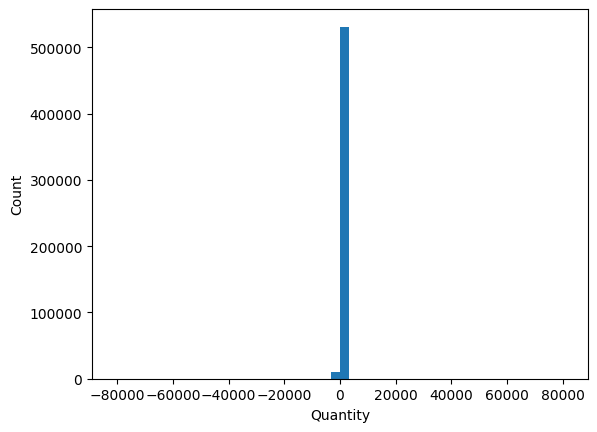

In [40]:
# Plot a histogram of the Quantity column
plt.hist(df_original['Quantity'], bins=50)
plt.xlabel('Quantity')
plt.ylabel('Count')
plt.show()

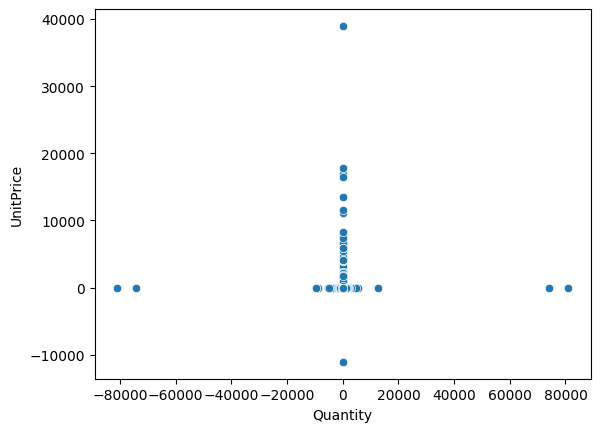

In [41]:
# Plot a scatter plot of Quantity vs UnitPrice
sns.scatterplot(x='Quantity', y='UnitPrice', data=df_original)
plt.show()

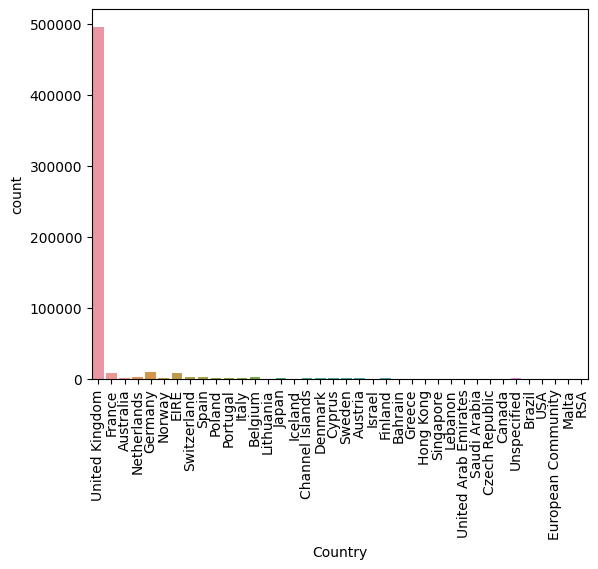

In [42]:
# Plot a bar chart of the number of transactions by country
sns.countplot(x='Country', data=df_original)
plt.xticks(rotation=90)
plt.show()

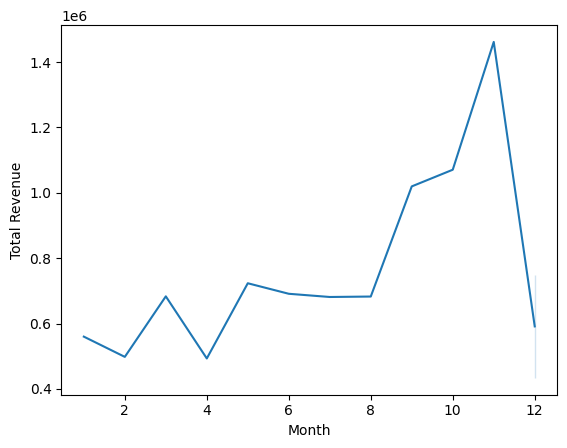

In [43]:
# Plot a line chart of the total revenue by month
df_original['InvoiceDate'] = pd.to_datetime(df_original['InvoiceDate'])
df_original['Month'] = df_original['InvoiceDate'].dt.month
df_original['Year'] = df_original['InvoiceDate'].dt.year
df_original['TotalRevenue'] = df_original['Quantity'] * df_original['UnitPrice']
monthly_revenue = df_original.groupby(['Year', 'Month'])['TotalRevenue'].sum().reset_index()
sns.lineplot(x='Month', y='TotalRevenue', data=monthly_revenue)
plt.xlabel('Month')
plt.ylabel('Total Revenue')
plt.show()

<Axes: >

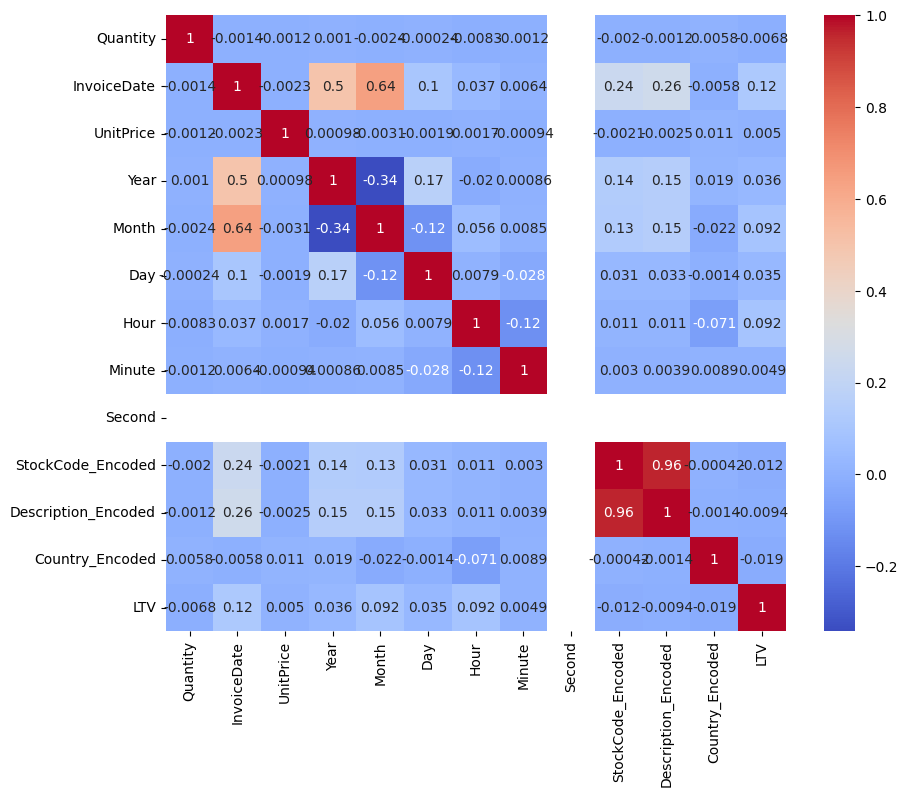

In [44]:
# create a correlation matrix
corr_matrix = df.corr()
fig, ax = plt.subplots(figsize=(10, 8))

# create a heatmap using the correlation matrix
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, ax=ax)


#### 5. Feature Importance

In [47]:
# Calculate feature importances
importances = rf_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(X_train.shape[1]):
    print("%d. %s (%f)" % (f + 1, X_train.columns[indices[f]], importances[indices[f]]))


Feature ranking:
1. InvoiceDate (0.397431)
2. Minute (0.189392)
3. Day (0.137090)
4. Hour (0.135573)
5. UnitPrice (0.042802)
6. Quantity (0.038126)
7. Country_Encoded (0.020197)
8. StockCode_Encoded (0.016163)
9. Description_Encoded (0.012261)
10. Month (0.010810)
11. Year (0.000154)
12. Second (0.000000)


#### 6. Recommendations

Based on the feature ranking output, we can identify which features have the highest impact on predicting the customer's LTV. The higher the importance score, the more impact that feature has on the model's prediction. Here are some recommendations based on the feature ranking:

1. InvoiceDate: As the most important feature, it appears that the date of the purchase plays a significant role in predicting customer LTV. It may be worthwhile to investigate further and see if there are any seasonal trends or patterns that can be leveraged for targeted marketing campaigns.

2. Minute, Day, and Hour: These features are also highly ranked and indicate that the time of day or week when a purchase is made could be important in predicting LTV. This could inform when marketing campaigns are run, or when to offer special deals or promotions.

3. UnitPrice and Quantity: These features have moderate importance scores, indicating that the value and quantity of items in a purchase may also be relevant to predicting LTV. Offering personalized recommendations or upsell opportunities based on a customer's past purchases could increase their LTV.

4. Country, StockCode, and Description: These features have lower importance scores, but are still worth considering. Understanding which countries, products, and descriptions are most popular among high-LTV customers could help inform marketing and inventory decisions.

Overall, the feature ranking provides valuable insights into which features have the most impact on predicting customer LTV. By using this information, businesses can tailor their marketing and sales strategies to better engage high-LTV customers and increase their lifetime value.